In [1]:
import cdsapi
import climetlab as cml
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import geopy
import xarray as xr
import pandas as pd

import csv
import os
import pickle

import scipy
import sklearn 
from sklearn.cluster import KMeans

import seaborn as sns

Read V2 Table

In [2]:
def read_table_v2():
    ft = pd.read_csv("../tables/state_regularized_v2.csv")
    for row in ft.iterrows():
        print(row[1]['State'])
    return ft

In [3]:
ft = read_table_v2()

nan
Oklahoma
Missouri
Michigan
New York
Florida
Louisiana
California
Connecticut
Arkansas
Virginia
California
California
Pennsylvania
Pennsylvania
North Carolina
Michigan
New York
North Carolina
Georgia
MichigaDIRTY
Wisconsin
Michigan
Indiana, Ohio
Illinois
Illinois
Ohio
Virginia
Texas
Pennsylvania
Maryland
Maryland
North Carolina, Virginia
North Carolina
Maryland
Pennsylvania, Maryland, Virginia
North Carolina
Maryland
All PPL includingDIRTY
California
Maryland, Virginia
Illinois
Michigan
Michigan
Maryland
Virginia
New York
Washington
Eastern portions of King County and Pierce CountyDIRTY
California
California
California
King CountyDIRTY
North Carolina, South Carolina
South Carolina
Georgia
Maryland
Pennsylvania, Maryland, Virginia
California
California
Georgia
Texas
North Carolina, South Carolina
Texas
Florida
Washington
California
Texas
Michigan
MichigaDIRTY
Michigan
West Virginia, Pennsylvania, Maryland, Virginia
Ohio
Ohio
Texas
Oklahoma
Louisiana
Nebraska
Alabama, Georgia
Virginia

Testing purposes.
Check values

In [37]:
means = xr.open_dataset('../../a/state_means/global_mean.nc')
x = xr.open_dataset('../../a/era5_data/12-31-2022.nc')

currLocation = geopandas.tools.geocode("Arkansas")
lat = currLocation.geometry.y.values[0]
lon = currLocation.geometry.x.values[0] + 360.

# print(means)

state_mean = means.sel(latitude=slice(lat+2.5,lat-2.5), longitude=slice(lon-2.5,lon+2.5),time='2022-12-01')
# print(state_mean.sf)
locate =  x.sel(latitude=slice(lat+2.5,lat-2.5), longitude=slice(lon-2.5,lon+2.5), time='2022-12-31T12:00:00')

print(state_mean.tp.to_dataframe())
print(locate.tp.to_dataframe())


                         time        tp
latitude longitude                     
37.50    265.25    2022-12-01  0.001386
         265.50    2022-12-01  0.001536
         265.75    2022-12-01  0.001661
         266.00    2022-12-01  0.001661
         266.25    2022-12-01  0.001659
...                       ...       ...
32.75    269.00    2022-12-01  0.004173
         269.25    2022-12-01  0.004346
         269.50    2022-12-01  0.004368
         269.75    2022-12-01  0.004212
         270.00    2022-12-01  0.004014

[400 rows x 2 columns]
                                  time        tp
latitude longitude                              
37.50    265.25    2022-12-31 12:00:00  0.000000
         265.50    2022-12-31 12:00:00  0.000000
         265.75    2022-12-31 12:00:00  0.000000
         266.00    2022-12-31 12:00:00  0.000000
         266.25    2022-12-31 12:00:00  0.000000
...                                ...       ...
32.75    269.00    2022-12-31 12:00:00  0.000232
         269.25

Define states

In [4]:
states = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

Testing for wind data

In [5]:
def wind_test(ft):
    means = xr.open_dataset('../../a/state_means/global_mean.nc')
    x = xr.open_dataset('../../a/era5_data/12-31-2022.nc')

    currLocation = geopandas.tools.geocode("Oregon")
    lat = currLocation.geometry.y.values[0]
    lon = currLocation.geometry.x.values[0] + 360.

    # print(means)

    state_mean = means.sel(latitude=slice(lat+2.5,lat-2.5), longitude=slice(lon-2.5,lon+2.5),time='2022-12-01')
    # print(state_mean.sf)
    locate =  x.sel(latitude=slice(lat+2.5,lat-2.5), longitude=slice(lon-2.5,lon+2.5), time='2022-12-31T12:00:00')

    print(state_mean.tp.to_dataframe())
    print(locate.tp.to_dataframe())


   

In [ ]:
wind_test(ft)

Accumulate data for all variables

In [4]:
def accumulate_state_data(ft):
    start = False
    state_dfs_raw = {}
    state_dfs_anom = {}
    for state in states:
        currLocation = geopandas.tools.geocode(state)
        sdf_raw = pd.DataFrame()
        sdf_anom = pd.DataFrame()
        print(state)
        for row in ft.iterrows():
            i = row[1]

            if "nan"in str(i['State']) or "DIRTY" in str(i['State']):
                continue
            if state not in str(i['State']):
                continue



            means = xr.open_dataset('../../a/state_means/global_mean.nc')

            date = str(i['Valid Date']).split('-')


            file_name = date[1] + '-' + date[2] + '-' + date[0] + '.nc'
            x = xr.open_dataset('../../a/era5_data/' + file_name)
            
            datetime = str(i['Valid Date']) + 'T12:00:00'




            lat = currLocation.geometry.y.values[0]
            lon = currLocation.geometry.x.values[0] + 360.

            state_mean = means.sel(latitude=slice(lat+2.5,lat-2.5), longitude=slice(lon-2.5,lon+2.5),time=date[0] + '-' + date[1] + '-01')
        
            locate =  x.sel(latitude=slice(lat+2.5,lat-2.5), longitude=slice(lon-2.5,lon+2.5), time=datetime)

            anom_t2m = locate.t2m.to_dataframe() - state_mean.t2m.to_dataframe()

            raw_t2m = locate.t2m.to_dataframe()

            raw_tp_col = locate.tp.to_dataframe()["tp"]
            
            
            
            raw_pd = pd.concat([raw_t2m, raw_tp_col, raw_sf_col], axis=1)

            # anom_tp_col = anom_tp["tp"]
            # anom_sf_col = anom_sf["sf"]
            anom_pd = pd.concat([anom_t2m, anom_tp_col, anom_sf_col], axis=1)

            # print(raw_pd)
            # print(anom_pd)

            sdf_raw = pd.concat([sdf_raw,raw_pd])
            sdf_anom = pd.concat([sdf_anom,anom_pd])
        state_dfs_raw[state] = sdf_raw
        state_dfs_anom[state] = sdf_anom


            


        
        


Alaska
Alabama
2004-06-23
2004-07-25
2004-09-06
2004-09-15
2004-09-16
2005-01-29
2005-04-30
2005-07-10
2005-07-10
2005-08-29
2005-08-29
2006-04-08
2007-03-01
2008-02-26
2008-03-15
2008-08-02
2008-08-24
2009-04-10
2011-04-04
2011-04-26
2011-04-27
2011-04-27
2011-06-22
2011-06-24
2011-06-26
2011-09-05
2012-03-02
2012-06-11
2013-03-18
2014-04-29
2014-04-29
2014-04-30
2014-06-07
2014-10-14
2015-01-07
2015-02-16
2015-02-18
2015-07-14
2017-01-22
2017-04-03
2017-05-04
2017-05-27
2017-06-15
2017-10-08
2017-12-08
2018-03-19
2018-06-28
2018-10-10
2018-12-09
2019-04-18
2019-06-22
2020-01-11
2020-03-31
2020-04-12
2020-04-20
2020-04-23
2020-06-27
2020-09-15
2020-09-16
2020-10-28
2020-10-29
2021-04-24
2021-05-04
2022-01-03
2022-01-16
2022-03-12
2022-03-31
2022-11-30
2022-12-23
2022-12-24
2023-01-12
2023-03-03
Arkansas
2002-12-03
2005-08-20
2005-09-23
2006-03-09
2008-01-29
2008-02-12
2008-04-04
2008-08-31
2008-09-12
2009-01-27
2009-01-27
2009-06-12
2009-10-09
2010-02-12
2011-04-04
2011-04-19
2011-04-

In [37]:
# def custom_upper_plot(x, y, **kwargs):
#     ax = plt.gca()
#     xlim = ax.get_xlim()  # Get initial x-axis limits
#     ylim = ax.get_ylim()  # Get initial y-axis limits
#     sns.scatterplot(x=y, y=x, **kwargs)
#     ax.set_xlim(ylim)  # Set x-axis limits to initial y-axis limits
#     ax.set_ylim(xlim)  # Set y-axis limits to initial x-axis limits
print(state_dfs_anom)

g = sns.PairGrid(state_dfs_anom["California"], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("State Anomaly Pair Density California")

    # sc = sns.scatterplot(state_dfs_anom['Oregon'])

    # plt.savefig("../visuals/tests/raw_pair_density_" + i + ".png")

{'Alaska': Empty DataFrame
Columns: []
Index: [], 'Alabama':                                time       t2m        tp   sf
latitude longitude                                          
35.75    270.75    22 days 12:00:00 -4.756439 -0.003245  0.0
         271.00    22 days 12:00:00 -4.582214 -0.003364  0.0
         271.25    22 days 12:00:00 -4.411957 -0.003518  0.0
         271.50    22 days 12:00:00 -4.179474 -0.003559  0.0
         271.75    22 days 12:00:00 -3.907471 -0.003709  0.0
...                             ...       ...       ...  ...
31.00    274.50     2 days 12:00:00  3.826691 -0.003720  0.0
         274.75     2 days 12:00:00  3.080200 -0.003475  0.0
         275.00     2 days 12:00:00  2.509460 -0.003247  0.0
         275.25     2 days 12:00:00  2.148926 -0.003162  0.0
         275.50     2 days 12:00:00  1.834015 -0.003205  0.0

[28800 rows x 4 columns], 'Arkansas':                                time       t2m        tp        sf
latitude longitude                       

/data/keeling/a/rct4/anaconda3/envs/workenv/lib/python3.9/site-packages/seaborn/axisgrid.py:1280: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


Text(0.5, 0.98, 'State Raw Pair Density Oregon')

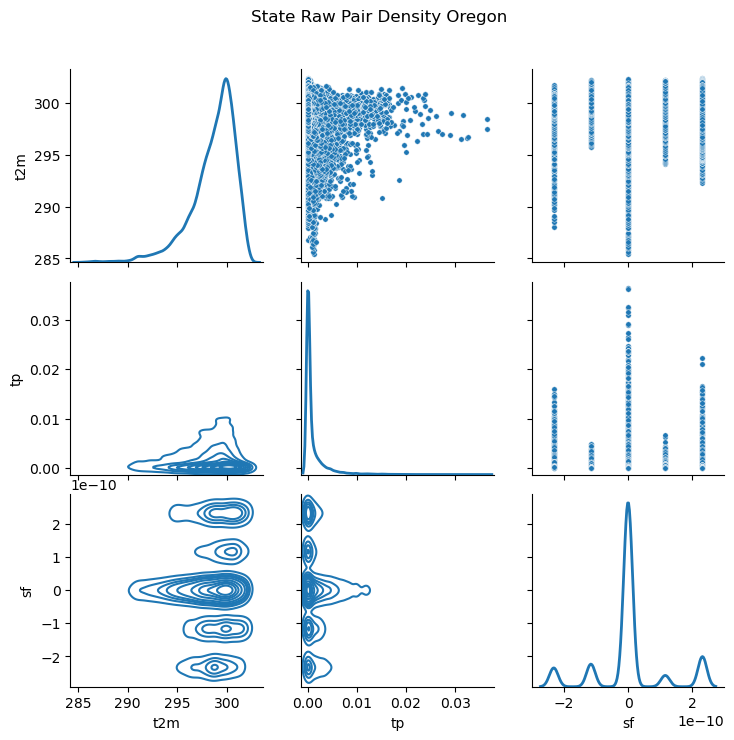

In [38]:
# def custom_upper_plot(x, y, **kwargs):
#     ax = plt.gca()
#     sns.scatterplot(x=y, y=x, **kwargs)
#     ax.set_xlim(ax.get_ylim())  # Swap x and y axes limits

g = sns.PairGrid(state_dfs_raw['Florida'], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("State Raw Pair Density " + "Oregon")

# sc = sns.scatterplot(state_dfs_anom['Oregon'])

# plt.savefig("../visuals/tests/raw_pair_density_" + i + ".png")

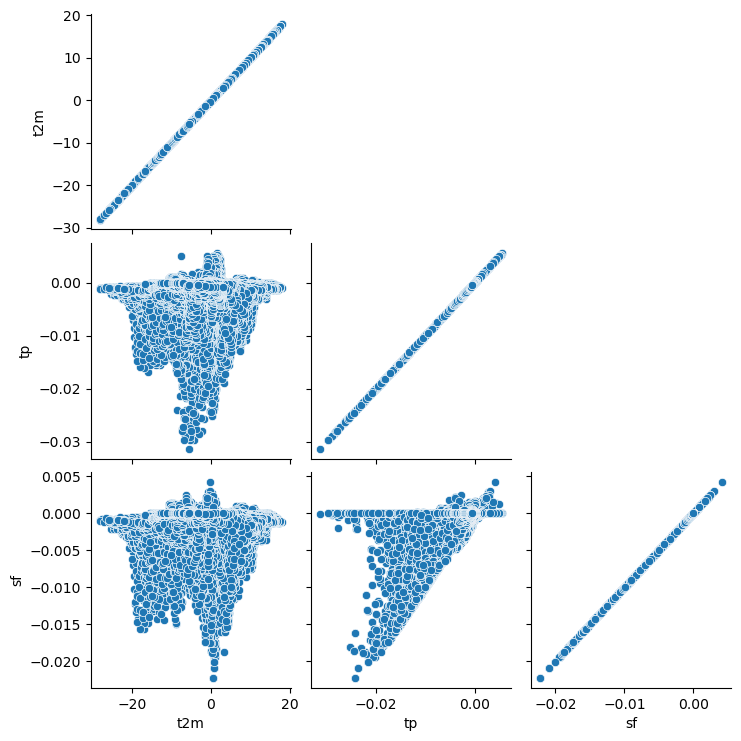

In [28]:
sc = sns.pairplot(state_dfs_anom['Oregon'], corner="lower", diag_kind=None)

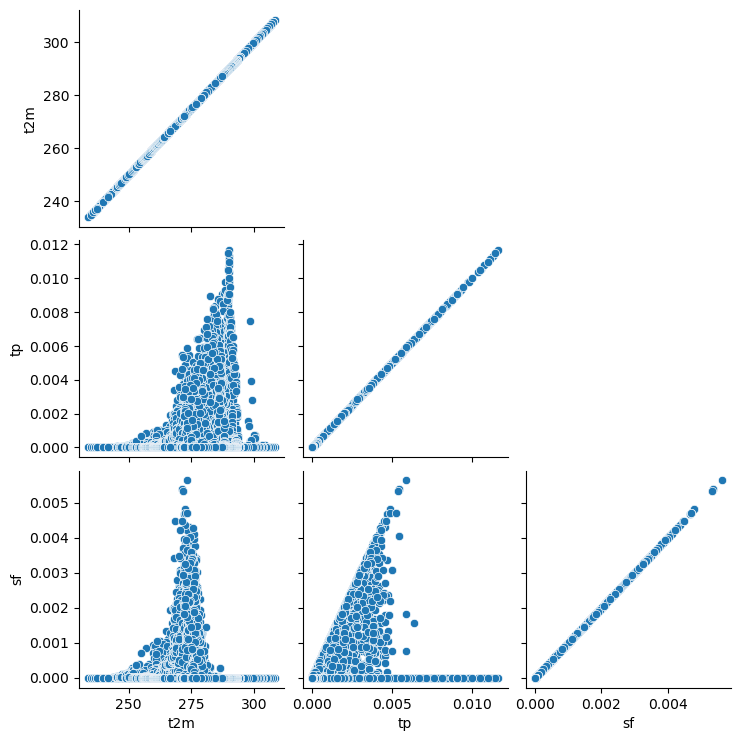

In [32]:
sc = sns.pairplot(state_dfs_raw['Oregon'], corner="lower", diag_kind=None)